In [107]:
## 모듈 로딩
## - 데이터 분석 및 시각화
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm   # 진행상황 시각화 (프로그레스바 progressbar)

## 한국어_자연어_처리 형태소 분석기
from konlpy.tag import Okt         

## - Pytorch 관련
import torch

## - 데이터셋 : 학습용/검증용/테스트용 분리
from sklearn.model_selection import train_test_split

## - Vocab 생성 시 단어 빈도 처리 위한 python 기본 모듈
from collections import Counter


In [108]:
## 데이터 준비
DATA_FILE_TRAIN = '../data/open/train_data.csv'                                                                                                                                                                                                                                                                                                                                                                                                                                                              
DATA_FILE_TEST = '../data/open/test_data.csv'

In [109]:
train_df=pd.read_csv(DATA_FILE_TRAIN)
test_df=pd.read_csv(DATA_FILE_TEST)

In [110]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45654 entries, 0 to 45653
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index      45654 non-null  int64 
 1   title      45654 non-null  object
 2   topic_idx  45654 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.0+ MB


In [111]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9131 entries, 0 to 9130
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   9131 non-null   int64 
 1   title   9131 non-null   object
dtypes: int64(1), object(1)
memory usage: 142.8+ KB


In [112]:
print('결측값 여부 :',train_df.isnull().values.any())

결측값 여부 : False


In [113]:
print('레이블 개수')
print(train_df.groupby('title').size().reset_index(name='count')) 

레이블 개수
                                   title  count
0        070 스팸전화 인식 탓 인터넷전화 가입자 24만명 감소      1
1              1.4㎏ 신경 덩어리 뇌의 신비 언제쯤 풀릴까      1
2            1004·4989 인기번호 알뜰폰 가입자도 받아요      1
3           1004·7942 이동전화 선호번호 범위 대폭 확대      1
4       100년 넘은 미주 최후 멕시코 태평양 섬 교도소 문닫는다      1
...                                  ...    ...
45649  女배구대표팀 세계 1위 세르비아와 VNL 2차전서 13...      1
45650      女아나운서 채용 차별 대전MBC 인권위 권고 이행하라      1
45651   女축구 윤덕여 감독 끝이 아닌 시작…프랑스월드컵 선전하겠다      1
45652  女프로배구 4개팀 시범경기 일정 확정…용병 거포 디우프 출격      1
45653    女프로배구 기업은행 새 감독에 김우재 강릉여고 감독 내정      1

[45654 rows x 2 columns]


In [114]:
X_data = train_df['title'].tolist()
y_data = train_df['topic_idx'].tolist()

### 데이터셋 분리 : 학습용/검증용/테스트용

In [115]:
## 데이터셋 분리 : 학습용/검증용/테스트용
# 4. train / valid+test 먼저 나누기 (30%)

X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, 
                                                    test_size=0.3, 
                                                    random_state=42, 
                                                    stratify=y_data)


In [116]:
# 5. valid / test 나누기 (15%씩)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, 
                                                test_size=0.5, 
                                                random_state=42, 
                                                stratify=y_temp)

In [117]:
# 확인
print(f'학습 데이터 크기 : {len(X_train)}')
print(f'검증 데이터 크기 : {len(X_val)}')
print(f'테스트 데이터 크기 : {len(X_test)}')

학습 데이터 크기 : 31957
검증 데이터 크기 : 6848
테스트 데이터 크기 : 6849


### 단어사전 생성 

In [118]:
from collections import Counter
from konlpy.tag import Okt
okt = Okt()
okt_morphs = [okt.morphs(sent) for sent in X_train]

In [119]:
# 토큰화 함수 정의
def tokenize(sentences):
    tokenized_sentences = []
    for sent in tqdm(sentences, desc="Tokenizing"):
        tokens = okt.morphs(sent)
        tokens = [word.lower() for word in tokens]
        # 불용어 제거, 원형복원, 구두점 추가해서 정리 
        tokenized_sentences.append(tokens)
    return tokenized_sentences


In [120]:
# 실제 토큰화 수행
tokenized_X_train = tokenize(X_train)
tokenized_X_val = tokenize(X_val)
tokenized_X_test = tokenize(X_test)

Tokenizing: 100%|██████████| 6849/6849 [00:06<00:00, 986.63it/s] 


In [121]:
# 상위 샘플 2개 출력
for sent in tokenized_X_train[:2]:
  print(sent)

['바르사', '알라베스', '국왕컵', '결승', '레알', '마드리드', '안방', '에선', '안', '돼']
['lgu', '경기도', '시흥', '서', '5', 'g', '드론', '시연', '…', 'ai', '음성', '명령', '으로', '제어']


### Vocab 생성 

In [122]:
## 단어 추출 후 단어 빈도 처리 
word_list = []
for sent in tokenized_X_train:
    for word in sent:
      word_list.append(word)

word_counts = Counter(word_list)
print('총 단어수 :', len(word_counts))

총 단어수 : 30817


In [123]:
vocab = sorted(word_counts, key=word_counts.get, reverse=True)
print('등장 빈도수 상위 10개 단어')
print(vocab[:10])

print('등장 빈도수 하위 10개 단어')
print(vocab[-10:])

등장 빈도수 상위 10개 단어
['…', '에', '·', '종합', '서', '의', '로', '한', '2', '명']
등장 빈도수 하위 10개 단어
['조급함', '입체파', '혁명가', '미운', '우동기', '버르장머리', '고치겠다', '전조', '쐈지만', '시큰둥']


In [124]:
threshold  = 3
total_cnt  = len(word_counts) # 단어의 수
rare_cnt   = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq  = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30817
등장 빈도가 2번 이하인 희귀 단어의 수: 18080
단어 집합에서 희귀 단어의 비율: 58.668916507122695
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.481169613344827


In [125]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
vocab_size = total_cnt - rare_cnt
vocab = vocab[:vocab_size]
print('단어 집합의 크기 :', len(vocab))

단어 집합의 크기 : 12737


In [126]:
## 단어사전 => 단어:정수값 
word_to_index = {}
word_to_index['<PAD>'] = 0
word_to_index['<UNK>'] = 1

In [127]:
for index, word in enumerate(vocab) :
  word_to_index[word] = index + 2

In [128]:
vocab_size = len(word_to_index)
print('패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 :', vocab_size)

패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 : 12739


In [129]:
print('단어 <PAD>와 맵핑되는 정수 :', word_to_index['<PAD>'])
print('단어 <UNK>와 맵핑되는 정수 :', word_to_index['<UNK>'])

단어 <PAD>와 맵핑되는 정수 : 0
단어 <UNK>와 맵핑되는 정수 : 1


### 정수 인코딩 

In [130]:
## 문장 단위 추출 후 단어들을 정수로 인코딩 진행 함수 
def texts_to_sequences(tokenized_X_data, word_to_index):
  encoded_X_data = []
  for sent in tokenized_X_data:
    index_sequences = []
    for word in sent:
      # index_sequences.append(word_to_index.get(word, '<UNK>'))
      try:
          index_sequences.append(word_to_index[word])
      except KeyError:
          index_sequences.append(word_to_index['<UNK>'])
    encoded_X_data.append(index_sequences)
  return encoded_X_data

In [131]:
# 1. 토큰화 (변수명 통일: train / val / test)
# tokenized_X_train = tokenize(X_train)
# tokenized_X_val = tokenize(X_val)
# tokenized_X_test = tokenize(X_test)

# 2. 정수 인코딩
encoded_X_train = texts_to_sequences(tokenized_X_train, word_to_index)
encoded_X_val = texts_to_sequences(tokenized_X_val, word_to_index)
encoded_X_test = texts_to_sequences(tokenized_X_test, word_to_index)


In [173]:
# 상위 샘플 2개 출력
for sent in encoded_X_train[:2]:
  print(sent)

for sent in tokenized_X_train[:2]:
  print(sent)

[2102, 1, 7559, 879, 1690, 1825, 3842, 3257, 59, 319]
[455, 1110, 1, 6, 26, 51, 706, 2460, 2, 141, 1640, 1776, 20, 3118]
['바르사', '알라베스', '국왕컵', '결승', '레알', '마드리드', '안방', '에선', '안', '돼']
['lgu', '경기도', '시흥', '서', '5', 'g', '드론', '시연', '…', 'ai', '음성', '명령', '으로', '제어']


In [133]:
## 정수 => 단어 변환 사전 ( 예 : 영한사전, 기계어자연어사전 )
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value] = key

In [134]:
decoded_sample = [index_to_word[word] for word in encoded_X_train[0]]
print('기존의 첫번째 샘플 :', tokenized_X_train[0])
print('복원된 첫번째 샘플 :', decoded_sample)

기존의 첫번째 샘플 : ['바르사', '알라베스', '국왕컵', '결승', '레알', '마드리드', '안방', '에선', '안', '돼']
복원된 첫번째 샘플 : ['바르사', '<UNK>', '국왕컵', '결승', '레알', '마드리드', '안방', '에선', '안', '돼']


### 패딩

리뷰의 최대 길이 : 22
리뷰의 평균 길이 : 10.962793754107082


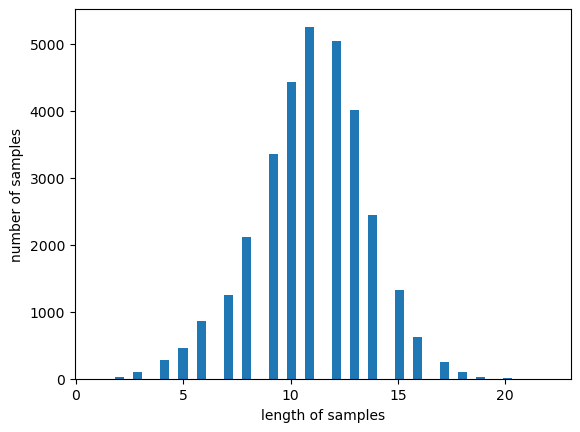

In [135]:
print('리뷰의 최대 길이 :',max(len(review) for review in encoded_X_train))
print('리뷰의 평균 길이 :',sum(map(len, encoded_X_train))/len(encoded_X_train))
plt.hist([len(review) for review in encoded_X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()


In [136]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [137]:
max_len = 500
below_threshold_len(max_len, encoded_X_train)

전체 샘플 중 길이가 500 이하인 샘플의 비율: 100.0


In [138]:
def pad_sequences(sentences, max_len):
  features = np.zeros((len(sentences), max_len), dtype=int)
  for index, sentence in enumerate(sentences):
    if len(sentence) != 0:
      features[index, :len(sentence)] = np.array(sentence)[:max_len]
  return features

In [139]:
#pip install tensorflow

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences 

# 최대 길이 설정 (예시: 그래프에서 본 최대값 14)
max_len = 14  # 또는 평균+표준편차 고려해서 설정

# 패딩 적용 (변수명 일치시켜야 함!)
padded_X_train = pad_sequences(encoded_X_train, maxlen=max_len, padding='post', truncating='post')
padded_X_val   = pad_sequences(encoded_X_val, maxlen=max_len, padding='post', truncating='post')
padded_X_test  = pad_sequences(encoded_X_test, maxlen=max_len, padding='post', truncating='post')


In [141]:
print('훈련 데이터의 크기 :', padded_X_train.shape)
print('검증 데이터의 크기 :', padded_X_val.shape) 
print('테스트 데이터의 크기 :', padded_X_test.shape)

훈련 데이터의 크기 : (31957, 14)
검증 데이터의 크기 : (6848, 14)
테스트 데이터의 크기 : (6849, 14)


In [142]:
print(padded_X_train.shape[:2])

(31957, 14)


### 모델링

In [143]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [144]:
train_label_tensor = torch.tensor(np.array(y_train))
val_label_tensor   = torch.tensor(np.array(y_val))
test_label_tensor  = torch.tensor(np.array(y_test))

In [145]:
train_label_tensor[:5]

tensor([5, 0, 4, 4, 5], dtype=torch.int32)

In [146]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("cpu와 cuda 중 다음 기기로 학습함:", device)

cpu와 cuda 중 다음 기기로 학습함: cpu


In [147]:
# 1. 실제 입력 (예: padded_X_train은 (batch, seq_len) 모양의 정수 인코딩 텐서)
input = torch.tensor(padded_X_train[:32], dtype=torch.long)  # (32, 50) → 배치 크기 32, 문장 길이 50

# 2. 임베딩 적용
embedding = nn.Embedding(num_embeddings=len(word_to_index), embedding_dim=16, padding_idx=0)
embedded = embedding(input)  # (32, 50, 16)

# 3. Conv1d를 위해 (배치, 채널, 시퀀스 길이)로 차원 변경
embedded = embedded.permute(0, 2, 1)  # (32, 16, 50)

# 4. Conv1d 선언 및 적용
m = nn.Conv1d(in_channels=16, out_channels=33, kernel_size=3, stride=1)
output = m(embedded)

# 5. 출력 확인
print("Conv1d 결과 shape:", output.shape)  # (32, 33, 48)


Conv1d 결과 shape: torch.Size([32, 33, 12])


In [148]:
class CNN(torch.nn.Module):
  def __init__(self, vocab_size, num_labels):
    super(CNN, self).__init__()

    # 오직 하나의 종류의 필터만 사용함.
    self.num_filter_sizes = 1 # 윈도우 5짜리 1개만 사용
    self.num_filters = 256

    self.word_embed = torch.nn.Embedding(num_embeddings=vocab_size, embedding_dim=128, padding_idx=0)
    # 윈도우 5짜리 1개만 사용
    self.conv1 = torch.nn.Conv1d(128, self.num_filters, 5, stride=1)
    self.dropout = torch.nn.Dropout(0.5)
    self.fc1 = torch.nn.Linear(1 * self.num_filters, num_labels, bias=True)

  def forward(self, inputs):
    # word_embed(inputs).shape == (배치 크기, 문장길이, 임베딩 벡터의 차원)
    # word_embed(inputs).permute(0, 2, 1).shape == (배치 크기, 임베딩 벡터의 차원, 문장 길이)
    embedded = self.word_embed(inputs).permute(0, 2, 1)

    # max를 이용한 maxpooling
    # conv1(embedded).shape == (배치 크기, 커널 개수, 컨볼루션 연산 결과) == ex) 32, 256, 496
    # conv1(embedded).permute(0, 2, 1).shape == (배치 크기, 컨볼루션 연산 결과, 커널 개수)
    # conv1(embedded).permute(0, 2, 1).max(1)[0]).shape == (배치 크기, 커널 개수)
    x = F.relu(self.conv1(embedded).permute(0, 2, 1).max(1)[0])

    # y_pred.shape == (배치 크기, 분류할 카테고리의 수)
    y_pred = self.fc1(self.dropout(x))

    return y_pred

In [149]:

# 변수 이름 통일
padded_X_valid = padded_X_val
valid_label_tensor = torch.tensor(y_val)

# Tensor 변환 및 Dataset 구성
encoded_train = torch.tensor(padded_X_train).to(torch.int64)
train_label_tensor = torch.tensor(y_train)
train_dataset = torch.utils.data.TensorDataset(encoded_train, train_label_tensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=32)

encoded_test = torch.tensor(padded_X_test).to(torch.int64)
test_label_tensor = torch.tensor(y_test)
test_dataset = torch.utils.data.TensorDataset(encoded_test, test_label_tensor)
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=1)

encoded_valid = torch.tensor(padded_X_valid).to(torch.int64)
valid_dataset = torch.utils.data.TensorDataset(encoded_valid, valid_label_tensor)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, shuffle=True, batch_size=1)


In [150]:
num_epochs = 5
total_batch = len(train_dataloader)
print('총 배치의 수 : {}'.format(total_batch))

총 배치의 수 : 999


In [151]:
model = CNN(vocab_size, num_labels = len(set(y_train)))
model.to(device)

CNN(
  (word_embed): Embedding(12739, 128, padding_idx=0)
  (conv1): Conv1d(128, 256, kernel_size=(5,), stride=(1,))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=256, out_features=7, bias=True)
)

In [152]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [153]:
def calculate_accuracy(logits, labels):
    # _, predicted = torch.max(logits, 1)
    predicted = torch.argmax(logits, dim=1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy

In [154]:
def evaluate(model, valid_dataloader, criterion, device):
    val_loss = 0
    val_correct = 0
    val_total = 0

    model.eval()
    with torch.no_grad():
        # 데이터로더로부터 배치 크기만큼의 데이터를 연속으로 로드
        for batch_X, batch_y in valid_dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # 모델의 예측값
            logits = model(batch_X)

            # 손실을 계산
            loss = criterion(logits, batch_y)

            # 정확도와 손실을 계산함
            val_loss += loss.item()
            val_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
            val_total += batch_y.size(0)

    val_accuracy = val_correct / val_total
    val_loss /= len(valid_dataloader)

    return val_loss, val_accuracy

In [155]:
# Training loop
best_val_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    # Training
    train_loss = 0
    train_correct = 0
    train_total = 0
    model.train()
    for batch_X, batch_y in train_dataloader:
        # Forward pass
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        # batch_X.shape == (batch_size, max_len)
        logits = model(batch_X)

        # Compute loss
        loss = criterion(logits, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training accuracy and loss
        train_loss += loss.item()
        train_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
        train_total += batch_y.size(0)

    train_accuracy = train_correct / train_total
    train_loss /= len(train_dataloader)

    # Validation
    val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # 검증 손실이 최소일 때 체크포인트 저장
    if val_loss < best_val_loss:
        print(f'Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. 체크포인트를 저장합니다.')
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_checkpoint.pth')

Epoch 1/5:
Train Loss: 1.3454, Train Accuracy: 0.5052
Validation Loss: 0.8904, Validation Accuracy: 0.6993
Validation loss improved from inf to 0.8904. 체크포인트를 저장합니다.
Epoch 2/5:
Train Loss: 0.7783, Train Accuracy: 0.7316
Validation Loss: 0.7362, Validation Accuracy: 0.7512
Validation loss improved from 0.8904 to 0.7362. 체크포인트를 저장합니다.
Epoch 3/5:
Train Loss: 0.5580, Train Accuracy: 0.8110
Validation Loss: 0.6716, Validation Accuracy: 0.7858
Validation loss improved from 0.7362 to 0.6716. 체크포인트를 저장합니다.
Epoch 4/5:
Train Loss: 0.4246, Train Accuracy: 0.8538
Validation Loss: 0.6619, Validation Accuracy: 0.7899
Validation loss improved from 0.6716 to 0.6619. 체크포인트를 저장합니다.
Epoch 5/5:
Train Loss: 0.3247, Train Accuracy: 0.8889
Validation Loss: 0.6881, Validation Accuracy: 0.8008


In [156]:
# 모델 로드
model.load_state_dict(torch.load('best_model_checkpoint.pth'))

# 모델을 device에 올립니다.
model.to(device)

# 검증 데이터에 대한 정확도와 손실 계산
val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

print(f'Best model validation loss: {val_loss:.4f}')
print(f'Best model validation accuracy: {val_accuracy:.4f}')

Best model validation loss: 0.6619
Best model validation accuracy: 0.7899


In [157]:
def predict(text, model, word_to_index, index_to_tag):
    # 모델 평가 모드
    model.eval()

    # 토큰화 및 정수 인코딩. OOV 문제 발생 시 <UNK> 토큰에 해당하는 인덱스 1 할당
    tokens = okt.morphs(text)  
    token_indices = [word_to_index.get(token.lower(), 1) for token in tokens]

    # 리스트를 텐서로 변경
    input_tensor = torch.tensor([token_indices], dtype=torch.long).to(device)  # (1, seq_length)

    # 모델의 예측
    with torch.no_grad():
        logits = model(input_tensor)  # (1, output_dim)

    # 레이블 인덱스 예측
    _, predicted_index = torch.max(logits, dim=1)  # (1,)

    # 인덱스와 매칭되는 카테고리 문자열로 변경
    predicted_tag = index_to_tag[predicted_index.item()]

    return predicted_tag

In [158]:
# 단어 집합 크기
vocab_size = len(word_to_index)  # 꼭 word_to_index 기반으로 설정

In [159]:
# RNN 단방향 모델 정의
class RNN(nn.Module):
    def __init__(self, vocab_size, hidden_dim, output_dim):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=128, padding_idx=0)
        self.rnn = nn.RNN(input_size=128, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)  # (batch, seq_len, embed_dim)
        output, hidden = self.rnn(embedded)  # hidden: (1, batch, hidden_dim)
        return self.fc(hidden.squeeze(0))  # (batch, output_dim)

In [160]:
# 모델 생성
model = RNN(vocab_size=vocab_size, hidden_dim=128, output_dim=len(set(y_train)))
model.to(device)


RNN(
  (embedding): Embedding(12739, 128, padding_idx=0)
  (rnn): RNN(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=7, bias=True)
)

In [161]:
# 손실함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [162]:
# 정확도 계산 함수
def calculate_accuracy(logits, labels):
    predicted = torch.argmax(logits, dim=1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    return correct / total

In [163]:
# 검증용 평가 함수
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss, total_correct, total = 0, 0, 0

    with torch.no_grad():
        for batch_X, batch_y in dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            logits = model(batch_X)
            loss = criterion(logits, batch_y)
            total_loss += loss.item()
            total_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
            total += batch_y.size(0)

    return total_loss / len(dataloader), total_correct / total

In [166]:
# 학습 루프
num_epochs = 20
best_val_loss = float('inf')

for epoch in range(num_epochs):
    train_loss, train_correct, train_total = 0, 0, 0
    model.train()

    for batch_X, batch_y in train_dataloader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        logits = model(batch_X)
        loss = criterion(logits, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
        train_total += batch_y.size(0)

    train_accuracy = train_correct / train_total
    train_loss /= len(train_dataloader)

    val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_rnn_model.pth')
        print("Best model saved.")

    

KeyboardInterrupt: 

In [168]:

num_epochs = 20
best_val_loss = float('inf')
patience = 3               # 몇 번 연속 성능 향상 없을 때 멈출지
no_improve_epochs = 0      # 성능 향상 안 된 에폭 수

for epoch in range(num_epochs):
    train_loss, train_correct, train_total = 0, 0, 0
    model.train()

    # ✅ tqdm 진행률 표시
    train_bar = tqdm(train_dataloader, desc=f"[에폭 {epoch+1}/{num_epochs}] 학습 중", leave=False)

    for batch_X, batch_y in train_bar:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        logits = model(batch_X)
        loss = criterion(logits, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
        train_total += batch_y.size(0)

        train_bar.set_postfix({
            "손실": f"{loss.item():.4f}"
        })

    train_accuracy = train_correct / train_total
    train_loss /= len(train_dataloader)

    val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

    print(f"\n📘 에폭 {epoch+1}/{num_epochs}")
    print(f"훈련 손실: {train_loss:.4f}, 훈련 정확도: {train_accuracy:.4f}")
    print(f"검증 손실: {val_loss:.4f}, 검증 정확도: {val_accuracy:.4f}")

    # ✅ 조기 종료 조건 확인
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve_epochs = 0
        torch.save(model.state_dict(), 'best_model1.pth')
        print("✅ 성능 향상: 모델 저장 완료.")
    else:
        no_improve_epochs += 1
        print(f"⚠️ 성능 향상 없음. ({no_improve_epochs}/{patience})")

        if no_improve_epochs >= patience:
            print("🛑 조기 종료: 검증 손실이 개선되지 않았습니다.")
            break



📘 에폭 1/20
훈련 손실: 0.1296, 훈련 정확도: 0.9666
검증 손실: 0.9586, 검증 정확도: 0.7830
✅ 성능 향상: 모델 저장 완료.



📘 에폭 2/20
훈련 손실: 0.1225, 훈련 정확도: 0.9680
검증 손실: 0.9915, 검증 정확도: 0.7750
⚠️ 성능 향상 없음. (1/3)



📘 에폭 3/20
훈련 손실: 0.1118, 훈련 정확도: 0.9718
검증 손실: 1.0502, 검증 정확도: 0.7815
⚠️ 성능 향상 없음. (2/3)



📘 에폭 4/20
훈련 손실: 0.1009, 훈련 정확도: 0.9729
검증 손실: 1.0317, 검증 정확도: 0.7839
⚠️ 성능 향상 없음. (3/3)
🛑 조기 종료: 검증 손실이 개선되지 않았습니다.


In [ ]:
# num_epochs = 20
# best_val_loss = float('inf')

# for epoch in range(num_epochs):
#     train_loss, train_correct, train_total = 0, 0, 0
#     model.train()

#     # tqdm으로 배치 단위 진행률 출력
#     progress_bar = tqdm(train_dataloader, desc=f"[에폭 {epoch+1}/{num_epochs}] 학습 중", leave=False)

#     for step, (batch_X, batch_y) in enumerate(progress_bar):
#         batch_X, batch_y = batch_X.to(device), batch_y.to(device)

#         logits = model(batch_X)
#         loss = criterion(logits, batch_y)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         train_loss += loss.item()
#         train_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
#         train_total += batch_y.size(0)

#         # 현재 진행률 퍼센트로 업데이트
#         percent = 100 * (step + 1) / len(train_dataloader)
#         progress_bar.set_postfix({
#             "진행률": f"{percent:.1f}%",
#             "현재 손실": f"{loss.item():.4f}"
#         })

#     train_accuracy = train_correct / train_total
#     train_loss /= len(train_dataloader)

#     val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

#     print(f'\n에폭 {epoch+1}/{num_epochs}')
#     print(f'훈련 손실: {train_loss:.4f}, 훈련 정확도: {train_accuracy:.4f}')
#     print(f'검증 손실: {val_loss:.4f}, 검증 정확도: {val_accuracy:.4f}')

#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         torch.save(model.state_dict(), 'best_rnn_model.pth')
#         print(" 검증 성능 향상 → 모델 저장됨.")

In [169]:
# 모델 로드 및 테스트 평가
model.load_state_dict(torch.load('best_rnn_model.pth'))
model.to(device)
test_loss, test_acc = evaluate(model, test_dataloader, criterion, device)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7906


In [170]:
model = CNN(vocab_size, num_labels = len(set(y_train)))


In [ ]:
NEWS = '../data/open/topic_dict.csv'
news_df = pd.read_csv(NEWS)
news_df

In [ ]:
test_df.head(2)

In [ ]:
train_df.head(2)

데이터 전처리

In [ ]:
## 모듈로딩
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [ ]:
train_df.iloc[:50,1]

In [ ]:
### ===> 문자 집합 생성
chars = sorted(list(set(train_df.iloc[:50,1])))
print(f'chars => {chars}')

vocab_size = len(chars)
print(f'vocab_size => ', vocab_size)

char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for i, ch in enumerate(chars)}

- 토큰화 -> 형태소 분석기 선택
- 단어 사전

형태소 분석


In [ ]:
## 형태소 분석기 인스턴스 객체 생성
okt_tokenizer= Okt()

In [ ]:
sample_datas=train_df.iloc[:50,1]

In [ ]:
# 불용어 추가

stopword_file = './koreanStopwords_unique.txt'

with open(stopword_file, mode='r', encoding='utf-8') as f:
    stop_words = f.readlines()

stop_words

In [ ]:
all_datas=train_df.iloc[:,1]

In [ ]:
# 문장 마다 토큰 분리
token_datas=[]
for sentence in all_datas:
    wtoken=okt_tokenizer.morphs(sentence)  # 명사만 morphs 말고 nouns
    # 불용어만 제거 (품사 제거 등 다른 작업도 해야 함)
    ww=[w for w in wtoken if w not in stop_words]
    token_datas.append(ww)

In [ ]:
# 문장 마다 토큰 분리
token_datas2=[]
for sentence in all_datas:
    wtoken=okt_tokenizer.nouns(sentence)  # 명사만 morphs 말고 nouns
    # 불용어만 제거 (품사 제거 등 다른 작업도 해야 함)
    ww=[w for w in wtoken if w not in stop_words]
    token_datas2.append(ww)

In [ ]:
print('문장별 토큰화 결과 : ', len(token_datas))
token_datas[:10]

In [ ]:
print('문장별 토큰화 결과 : ', len(token_datas2))
token_datas2[:10]

In [ ]:
wordList=[]
for tt in token_datas:
    print(tt)
    wordList += tt

In [ ]:
len(wordList), wordList[:10]

In [ ]:
## 중복된 단어 제거
key_list= set(wordList)
len(key_list), key_list

In [ ]:
## 단어/토큰별 빈도 수 정장을 위한 dict => 0으로 초기화
voca={ key: 0 for key in key_list}
voca

In [ ]:
## 단어/토큰별 빈도 수 저장
for word in wordList:
    voca[word] += 1

In [ ]:
## 데이터프레임에 저장
vocaDF=pd.DataFrame([voca]).T
vocaDF.head()

In [ ]:
#pip install openpyxl

In [ ]:
vocaDF.to_excel('voca_check.xlsx')

In [ ]:
## - 빈도순으로 정렬
vocaDF2=vocaDF.sort_values(0, ascending=False)
vocaDF2

In [ ]:
vocaDF2[0].unique()

In [ ]:
from konlpy.tag import Okt

from torchtext.vocab import build_vocab_from_iterator

In [ ]:
### ===> 토큰관련 특별 문자
UNK = '<UNK>'
PAD = '<PAD>'

### 토큰화 인스턴스 생성
tokenizer = Okt()

In [ ]:
### ===> 토큰 제너레이터 함수 : 데이터 추출하여 토큰화 
def yield_tokens(data_iter):
    for label, text in data_iter:
        # 라벨, 텍스트 --> 텍스트 토큰화
        yield tokenizer.morphs(text, stem=True)

In [ ]:
### ===> 토큰화 및 단어/어휘 사전 생성
VOCAB = build_vocab_from_iterator(
    yield_tokens(train_df),
    min_freq=2,
    specials= [PAD, UNK],
    special_first=True
)

### <UNK> 인덱스 설정
VOCAB.set_default_index(VOCAB[UNK])  